# VAR Forecasting
This notebook runs through all the Python code used to assess VAR assumptions, determine lag order, and assess out-of-sample fit. It also includes the code to generate the figures used in the final report, and generate data files needed to run conditional and unconditional BVAR forecasts in R. Plots in this notebook also assess those forecasts.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

### THIS NOTEBOOK DRAWN FROM: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/ ###

In [2]:
# Import beef data
data = pd.read_csv("./data/beefdemand.csv")
data["date"] = data["date"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))

In [3]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],10) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(data, variables = data.columns[1:])    

,demandall_uncooked_beef_roasts_x,demandall_uncooked_beef_steaks_x,demandall_uncooked_ground_beef_x,demandall_uncooked_other_beef_x,cattle_x
demandall_uncooked_beef_roasts_y,1.000000,2.473866e-03,0.0,1.588954e-02,0.0
demandall_uncooked_beef_steaks_y,0.000411,1.000000e+00,0.0,1.462158e-03,0.0
demandall_uncooked_ground_beef_y,0.090667,1.148151e-03,1.0,2.162131e-02,0.0
demandall_uncooked_other_beef_y,0.000002,1.632000e-07,0.0,1.000000e+00,0.0
cattle_y,0.000000,8.200000e-09,0.0,1.662000e-07,1.0


In [4]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(data[data.columns[1:]])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
demandall_uncooked_beef_roasts ::  59.77     > 60.0627   =>   False
demandall_uncooked_beef_steaks ::  28.1      > 40.1749   =>   False
demandall_uncooked_ground_beef ::  10.82     > 24.2761   =>   False
demandall_uncooked_other_beef ::  2.2       > 12.3212   =>   False
cattle ::  0.26      > 4.1296    =>   False


In [5]:
# Create training-test split
train = data.iloc[:-24, 1:]
test = data.iloc[-24:, 1:]

In [6]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [7]:
# ADF Test on each column
for name, column in train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "demandall_uncooked_beef_roasts" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6702
 No. Lags Chosen       = 15
 Critical value 1%     = -3.46
 Critical value 5%     = -2.874
 Critical value 10%    = -2.574
 => P-Value = 0.0793. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "demandall_uncooked_beef_steaks" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.5218
 No. Lags Chosen       = 15
 Critical value 1%     = -3.46
 Critical value 5%     = -2.874
 Critical value 10%    = -2.574
 => P-Value = 0.1103. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "demandall_uncooked_ground_beef" 
    ----

In [8]:
# Take the first differencing
train_diffd = train.diff().dropna()

In [9]:
for name, column in train_diffd.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "demandall_uncooked_beef_roasts" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.2984
 No. Lags Chosen       = 15
 Critical value 1%     = -3.46
 Critical value 5%     = -2.875
 Critical value 10%    = -2.574
 => P-Value = 0.015. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "demandall_uncooked_beef_steaks" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1085
 No. Lags Chosen       = 15
 Critical value 1%     = -3.46
 Critical value 5%     = -2.875
 Critical value 10%    = -2.574
 => P-Value = 0.0259. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "demandall_uncooked_ground_beef" 
    -----------------------------------------------
 

In [11]:
# Check lag order
model = VAR(train_diffd)
aic = []
for i in range(1,25):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')
    aic.append(result.aic)

C:\Users\natha\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Lag Order = 1
AIC :  -18.750973925949655
BIC :  -18.31459774788294
FPE :  7.187509089776925e-09
HQIC:  -18.575126338819587 

Lag Order = 2
AIC :  -18.9553347586533
BIC :  -18.152919266838463
FPE :  5.860650470731907e-09
HQIC:  -18.631946939852423 

Lag Order = 3
AIC :  -18.990208737212253
BIC :  -17.81955552501474
FPE :  5.663746225404799e-09
HQIC:  -18.518361366717226 

Lag Order = 4
AIC :  -18.929591887194533
BIC :  -17.38848027902636
FPE :  6.0257004212833655e-09
HQIC:  -18.30835641568961 

Lag Order = 5
AIC :  -18.88966799661417
BIC :  -16.97585473347059
FPE :  6.28487302138044e-09
HQIC:  -18.118106519312626 

Lag Order = 6
AIC :  -19.02293684129332
BIC :  -16.73415576060766
FPE :  5.5188080587629526e-09
HQIC:  -18.100101969597926 

Lag Order = 7
AIC :  -18.963457568888057
BIC :  -16.297419278579792
FPE :  5.884266798117702e-09
HQIC:  -17.888392299846508 

Lag Order = 8
AIC :  -19.288105233378598
BIC :  -16.242496779966558
FPE :  4.279820459287022e-09
HQIC:  -18.05984281688909 

La

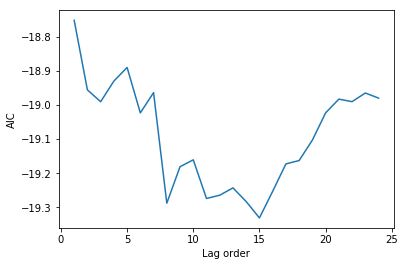

In [15]:
# Plot AIC vs. Lag Order
plt.plot(np.arange(1,25,1), aic[:25])
plt.xlabel("Lag order")
plt.ylabel("AIC")

In [16]:
x = model.select_order(maxlags = 20)
x.summary()

,AIC,BIC,FPE,HQIC
0,-17.87,-17.79,1.741e-08,-17.84
1,-18.47,-18.01*,9.507e-09,-18.28
2,-18.68,-17.83,7.708e-09,-18.34*
3,-18.72,-17.48,7.438e-09,-18.22
4,-18.66,-17.04,7.877e-09,-18.01
5,-18.62,-16.62,8.219e-09,-17.81
6,-18.76,-16.37,7.163e-09,-17.80
7,-18.71,-15.93,7.614e-09,-17.59
8,-19.04,-15.88,5.504e-09,-17.76
9,-18.95,-15.40,6.063e-09,-17.52


In [17]:
varfit = model.fit(15)
varfit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 01, May, 2020
Time:                     14:20:10
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -13.5619
Nobs:                     225.000    HQIC:                  -17.0028
Log likelihood:           958.472    FPE:                4.61793e-09
AIC:                     -19.3314    Det(Omega_mle):     1.07777e-09
--------------------------------------------------------------------
Results for equation demandall_uncooked_beef_roasts
                                        coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------------
const                                      0.001746         0.004134            0.422           0.673
L1.demandall_uncooked_beef_roasts         -0.247402  

In [18]:
# Durbin-Watson test for serial correlation of errors
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(varfit.resid)

for col, val in zip(train_diffd.columns, out):
    print(col, ':', round(val, 2))
    
# The closer to 2, the better -- we are very close to 2, so we have almost no serial correlation of errors

demandall_uncooked_beef_roasts : 1.96
demandall_uncooked_beef_steaks : 1.97
demandall_uncooked_ground_beef : 1.98
demandall_uncooked_other_beef : 1.98
cattle : 1.93


In [19]:
# Get the lag order
lag_order = varfit.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = train_diffd.values[-lag_order:]
forecast_input

15


array([[ 2.77140415e-02, -5.89213265e-02, -9.12611107e-03,
        -5.42549882e-03,  3.13000000e+01],
       [-8.83472996e-02, -7.31429754e-02, -5.06313063e-02,
         4.27066972e-03, -5.70000000e+01],
       [-3.00227147e-02, -3.54715396e-02, -1.55257139e-02,
        -4.42186440e-02, -3.51000000e+01],
       [-9.01228198e-02, -1.08565495e-01, -1.29406994e-01,
        -7.62978781e-02, -2.07700000e+02],
       [ 2.35208185e-01,  2.43716871e-01,  2.30794791e-01,
         1.26810949e-01,  3.99100000e+02],
       [-1.49187395e-01, -1.48683887e-01, -1.65774991e-01,
        -8.66802969e-02, -3.05000000e+02],
       [ 1.69923694e-01,  1.85482005e-01,  1.56501008e-01,
         1.39230144e-01,  2.90500000e+02],
       [ 1.15503207e-01,  1.48433313e-01,  9.10084617e-02,
         1.01600112e-01,  1.05200000e+02],
       [-1.55728927e-01, -1.21326987e-01, -1.17249150e-01,
        -9.33237921e-02, -2.47000000e+02],
       [ 1.36759377e-01,  1.46554570e-01,  1.78285841e-01,
         1.48315001e-01

In [20]:
# Forecast
nobs = 24 # Number of observations to forecast
fc = varfit.forecast(y=forecast_input, steps=24)
df_forecast = pd.DataFrame(fc, index=data["date"][-nobs:], columns=train_diffd.columns)
df_forecast

,demandall_uncooked_beef_roasts,demandall_uncooked_beef_steaks,demandall_uncooked_ground_beef,demandall_uncooked_other_beef,cattle
date,,,,,
2018-02-01,-0.152602,-0.209349,-0.157086,-0.113182,-248.211446
2018-03-01,0.061165,0.080313,0.082963,0.049562,142.249516
2018-04-01,0.025650,0.018309,-0.014840,0.028612,13.847488
2018-05-01,0.146525,0.182005,0.147205,0.129011,265.356873
2018-06-01,-0.034633,-0.016707,-0.012563,0.004848,-3.143160
2018-07-01,-0.046832,-0.071464,-0.038036,-0.045214,-50.140780
2018-08-01,0.174822,0.192166,0.166787,0.119187,323.932206
2018-09-01,-0.192336,-0.220942,-0.198849,-0.145683,-372.677764
2018-10-01,0.075399,0.079928,0.098823,0.089692,164.388713


In [21]:
# Un-Difference the numbers to get the real forecast values
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

In [22]:
df_results = invert_transformation(train, df_forecast, second_diff=False)

In [23]:
df_results

,demandall_uncooked_beef_roasts,demandall_uncooked_beef_steaks,demandall_uncooked_ground_beef,demandall_uncooked_other_beef,cattle,demandall_uncooked_beef_roasts_forecast,demandall_uncooked_beef_steaks_forecast,demandall_uncooked_ground_beef_forecast,demandall_uncooked_other_beef_forecast,cattle_forecast
date,,,,,,,,,,
2018-02-01,-0.152602,-0.209349,-0.157086,-0.113182,-248.211446,-0.091872,0.040639,-0.031113,0.038406,2509.888554
2018-03-01,0.061165,0.080313,0.082963,0.049562,142.249516,-0.030707,0.120953,0.051850,0.087968,2652.138070
2018-04-01,0.025650,0.018309,-0.014840,0.028612,13.847488,-0.005057,0.139262,0.037010,0.116580,2665.985558
2018-05-01,0.146525,0.182005,0.147205,0.129011,265.356873,0.141467,0.321267,0.184215,0.245591,2931.342431
2018-06-01,-0.034633,-0.016707,-0.012563,0.004848,-3.143160,0.106834,0.304560,0.171652,0.250439,2928.199271
2018-07-01,-0.046832,-0.071464,-0.038036,-0.045214,-50.140780,0.060002,0.233096,0.133616,0.205224,2878.058492
2018-08-01,0.174822,0.192166,0.166787,0.119187,323.932206,0.234824,0.425262,0.300403,0.324411,3201.990697
2018-09-01,-0.192336,-0.220942,-0.198849,-0.145683,-372.677764,0.042488,0.204320,0.101555,0.178728,2829.312934
2018-10-01,0.075399,0.079928,0.098823,0.089692,164.388713,0.117887,0.284248,0.200378,0.268420,2993.701647


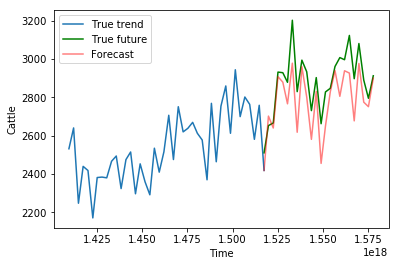

In [24]:
plt.plot(data["date"][200:-23], data["cattle"][200:-23], label = "True trend")
plt.plot(data["date"][-24:], df_results["cattle_forecast"], color = "green", label = "True future")
plt.plot(data["date"][-24:], data["cattle"][-24:], color = "red", label = "Forecast", alpha = 0.5)
plt.xlabel("Time")
plt.ylabel("Cattle")
plt.legend()

In [22]:
# Check the forecast accuracy by a variety of metrics
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: cattle')
accuracy_prod = forecast_accuracy(df_results['cattle_forecast'].values, test['cattle'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: cattle
mape :  0.0389
me :  102.3626
mae :  106.4844
mpe :  0.0374
rmse :  129.3876
corr :  0.871
minmax :  0.0368


# Bayesian VAR Forecasting in R
Now that we've shown a conventional VAR with lag 15 can succeed in forecasting cattle production, we want to instead use a flat-prior BVAR to forecast, first unconditionally, then conditionally on decreased demand for ground beef.

In [25]:
# First, take difference of entire training data, since we want to use this as input to the BVAR. Then, export for use in R.
data_difference = data.diff().dropna()

In [26]:
data_difference = data_difference[data_difference.columns[1:]]

In [27]:
data_difference.to_csv("diff_beefdemand.csv", header=False, index = False)

In [28]:
# Next, load in unconditional BVAR forecast results after running the relevant portion of bvar.rmd
bvar_uncon = pd.read_csv("bvar_unconditional.csv")
bvar_uncon = bvar_uncon.iloc[-120:]

In [29]:
bvar_uncon.head()

,V1,V2,V3,V4,V5
264,-0.302731,-0.321397,-0.336855,-0.253315,-624.944201
265,0.258072,0.298546,0.264982,0.202639,458.391461
266,0.118013,0.126728,0.088513,0.057160,134.841140
267,-0.013766,-0.008375,-0.021175,0.026318,-41.441824
268,0.111220,0.118785,0.108861,0.052168,187.820116


In [30]:
# Rename columns to match data DF
bvar_uncon.columns = data.columns[1:]

In [31]:
# un-difference the forecast results
bvar_uncon_results = invert_transformation(data[data.columns[1:]], bvar_uncon, second_diff=False)

In [32]:
bvar_uncon_results.head()

,demandall_uncooked_beef_roasts,demandall_uncooked_beef_steaks,demandall_uncooked_ground_beef,demandall_uncooked_other_beef,cattle,demandall_uncooked_beef_roasts_forecast,demandall_uncooked_beef_steaks_forecast,demandall_uncooked_ground_beef_forecast,demandall_uncooked_other_beef_forecast,cattle_forecast
264,-0.302731,-0.321397,-0.336855,-0.253315,-624.944201,-0.075765,0.008676,-0.080752,0.132389,2274.455799
265,0.258072,0.298546,0.264982,0.202639,458.391461,0.182308,0.307222,0.184230,0.335027,2732.847260
266,0.118013,0.126728,0.088513,0.057160,134.841140,0.300321,0.433950,0.272743,0.392187,2867.688400
267,-0.013766,-0.008375,-0.021175,0.026318,-41.441824,0.286555,0.425575,0.251568,0.418505,2826.246576
268,0.111220,0.118785,0.108861,0.052168,187.820116,0.397775,0.544360,0.360429,0.470672,3014.066692


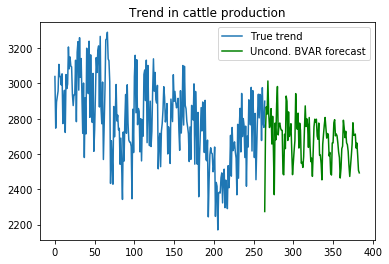

In [35]:
plt.plot(data.index, data["cattle"], label = "True trend")
plt.plot(bvar_uncon_results.index, bvar_uncon_results["cattle_forecast"], color = "green", label = "Uncond. BVAR forecast")
plt.legend()
plt.title("Trend in cattle production")

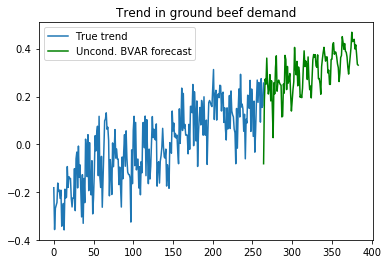

In [36]:
# Next, modify the values of ground beef demand five years into the future based off of your beliefs on the substitute product
plt.plot(data.index, data["demandall_uncooked_ground_beef"], label = "True trend")
plt.plot(bvar_uncon_results.index, bvar_uncon_results["demandall_uncooked_ground_beef_forecast"], color = "green", label = "Uncond. BVAR forecast")
plt.legend()
plt.title("Trend in ground beef demand")

In [37]:
# Using the hc.forecast method, that is forecasting using the Waggoner and Zha MCMC method to generate posterior Gibbs samples. Unconditional
bvar_uncon_mean = pd.read_csv("bvar_unconditional_mean.csv")
bvar_uncon_mean.columns = data.columns[1:]
bvar_uncon_lb = pd.read_csv("bvar_unconditional_lb.csv")
bvar_uncon_lb.columns = data.columns[1:]
bvar_uncon_ub = pd.read_csv("bvar_unconditional_ub.csv")
bvar_uncon_ub.columns = data.columns[1:]

In [38]:
# Redoing the diff.
bvar_uncon_mean = invert_transformation(data[data.columns[1:]], bvar_uncon_mean, second_diff=False)
bvar_uncon_lb = invert_transformation(data[data.columns[1:]], bvar_uncon_lb, second_diff=False)
bvar_uncon_ub = invert_transformation(data[data.columns[1:]], bvar_uncon_ub, second_diff=False)

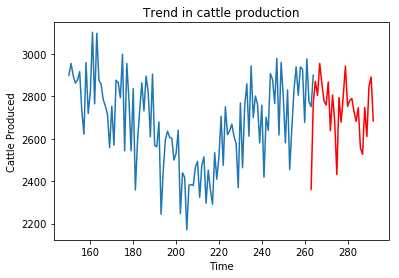

In [63]:
plt.plot(data.index[150:], data["cattle"][150:], label = "True trend")
# plt.plot(bvar_uncon_mean.index + data.index[-1] - 1, bvar_uncon_ub["cattle_forecast"], color = "green", label = "Uncond. BVAR forecast")
# plt.plot(bvar_uncon_mean.index + data.index[-1] - 1, bvar_uncon_lb["cattle_forecast"], color = "green", label = "Uncond. BVAR forecast")
plt.plot(bvar_uncon_mean.index + data.index[-1] - 1, bvar_uncon_mean["cattle_forecast"], color = "red", label = "Uncond. BVAR forecast")

plt.legend()
#plt.fill_between(bvar_uncon_mean.index + data.index[-1] - 1, bvar_uncon_ub["cattle_forecast"] - bvar_uncon_lb["cattle_forecast"])
plt.title("Trend in cattle production")
plt.xlabel("Time")
plt.ylabel("Cattle Produced")
plt.gca().legend().remove()

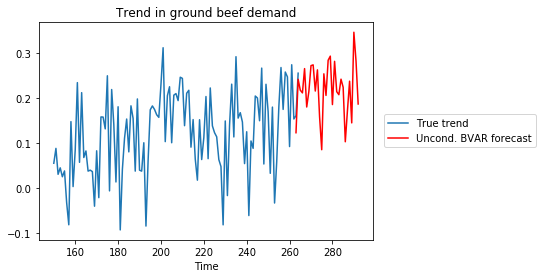

In [72]:
plt.plot(data.index[150:], data["demandall_uncooked_ground_beef"][150:], label = "True trend")
# plt.plot(bvar_uncon_mean.index + data.index[-1] - 1, bvar_uncon_ub["cattle_forecast"], color = "green", label = "Uncond. BVAR forecast")
# plt.plot(bvar_uncon_mean.index + data.index[-1] - 1, bvar_uncon_lb["cattle_forecast"], color = "green", label = "Uncond. BVAR forecast")
plt.plot(bvar_uncon_mean.index + data.index[-1] - 1, bvar_uncon_mean["demandall_uncooked_ground_beef_forecast"], color = "red", label = "Uncond. BVAR forecast")

plt.legend()
#plt.fill_between(bvar_uncon_mean.index + data.index[-1] - 1, bvar_uncon_ub["cattle_forecast"] - bvar_uncon_lb["cattle_forecast"])
plt.title("Trend in ground beef demand")
plt.gca().legend(bbox_to_anchor=(1.5,0.6))
plt.xlabel("Time")

In [34]:
# Next, export these values back into csv to be read into R

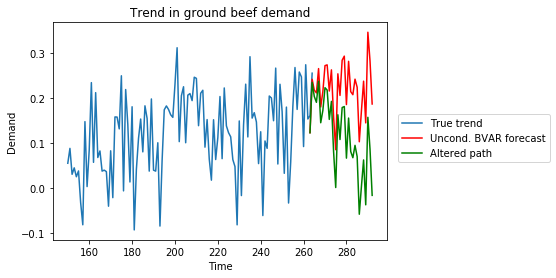

In [75]:
# Next, perform conditional BVAR forecasting and export those values from R into here
# Price of a substitute goes down, all else equal, you shift the demand curve to the left. Say this month we expect the introduction of a new 
# direct substitute, and we expect its price to lower by a constant amount each month as the business scales. 
plt.plot(data.index[150:], data["demandall_uncooked_ground_beef"][150:], label = "True trend")
plt.plot(bvar_uncon_mean.index + data.index[-1] - 1, bvar_uncon_mean["demandall_uncooked_ground_beef_forecast"], color = "red", label = "Uncond. BVAR forecast")
plt.plot(bvar_uncon_mean.index + data.index[-1] - 1, bvar_uncon_mean["demandall_uncooked_ground_beef_forecast"] - np.arange(0, 30*0.007, 0.007), color = "green", label = "Altered path")

plt.legend()
plt.title("Trend in ground beef demand")
plt.gca().legend(bbox_to_anchor=(1.5,0.6))
plt.xlabel("Time")
plt.ylabel("Demand")


In [42]:
# Make a new table to use as the conditioned path in an hc.forecast model
    # FIRST: Take the diff again to get it back to how it should look for the forecasting model
pre_dif = pd.read_csv("bvar_unconditional_mean.csv")
pre_dif.columns = data.columns[1:]
pre_dif.head()

,demandall_uncooked_beef_roasts,demandall_uncooked_beef_steaks,demandall_uncooked_ground_beef,demandall_uncooked_other_beef,cattle
0,-1.262090e-08,-0.157883,-0.132295,-0.160717,-538.569587
1,4.335116e-02,0.177423,0.118734,0.137912,410.483997
2,-5.845026e-02,0.032434,-0.024223,0.006620,98.833208
3,1.360912e-02,0.007386,-0.005983,0.024611,-66.395101
4,3.166055e-02,0.068772,0.053956,0.033642,151.187361


In [43]:
all_data = data[data.columns[1:]]
all_data.head()

,demandall_uncooked_beef_roasts,demandall_uncooked_beef_steaks,demandall_uncooked_ground_beef,demandall_uncooked_other_beef,cattle
0,-0.162558,-0.247646,-0.180993,-0.104235,3039.4
1,-0.309042,-0.437788,-0.355746,-0.231144,2746.8
2,-0.224620,-0.332842,-0.266849,-0.167936,2894.5
3,-0.226051,-0.305250,-0.254692,-0.168470,2927.1
4,-0.206118,-0.299824,-0.242371,-0.169622,2957.2


In [44]:
bvar_uncon_mean_sub = bvar_uncon_mean.copy()[bvar_uncon_mean.columns[5:]]

In [45]:
bvar_uncon_mean_sub.columns = [x[:-9] for x in bvar_uncon_mean_sub.columns]

In [46]:
# Create dataframe to be used as "yconst" fixed paths in hc.forecast method of MSBVAR in R
bvar_uncon_mean_sub.head()
bvar_uncon_mean_sub["demandall_uncooked_ground_beef"] = bvar_uncon_mean_sub["demandall_uncooked_ground_beef"] - np.arange(0,30*0.007, 0.007)
bvar_uncon_mean_sub["cattle"] = np.repeat(0,30)
bvar_uncon_mean_sub.head()


,demandall_uncooked_beef_roasts,demandall_uncooked_beef_steaks,demandall_uncooked_ground_beef,demandall_uncooked_other_beef,cattle
0,0.226967,0.172190,0.123808,0.224986,0
1,0.270318,0.349612,0.235542,0.362898,0
2,0.211868,0.382047,0.204319,0.369518,0
3,0.225477,0.389433,0.191335,0.394130,0
4,0.257137,0.458206,0.238292,0.427772,0


In [47]:
cond_values = all_data.append(bvar_uncon_mean_sub).diff().iloc[-30:]

In [48]:
cond_values.at[0,"cattle"] = 0

In [49]:
cond_values.to_csv("conditional_yvals.csv", header = False, index = False)

In [56]:
# Load Conditional forecast results after running relevant sections of bvar.rmd
bvar_con_mean = pd.read_csv("bvar_conditional_mean.csv")
bvar_con_mean.columns = data.columns[1:]
bvar_con_mean = invert_transformation(data[data.columns[1:]], bvar_con_mean, second_diff=False)

In [57]:
bvar_con_mean.head()

,demandall_uncooked_beef_roasts,demandall_uncooked_beef_steaks,demandall_uncooked_ground_beef,demandall_uncooked_other_beef,cattle,demandall_uncooked_beef_roasts_forecast,demandall_uncooked_beef_steaks_forecast,demandall_uncooked_ground_beef_forecast,demandall_uncooked_other_beef_forecast,cattle_forecast
0,-1.783090e-08,-0.151139,-0.131239,-0.153750,-526.438895,0.226967,0.178934,0.124864,0.231953,2372.961105
1,8.578904e-02,0.194460,0.142460,0.143200,400.615802,0.312756,0.373394,0.267324,0.375154,2773.576907
2,-1.099079e-01,0.004700,-0.057435,-0.008254,90.432191,0.202848,0.378095,0.209888,0.366900,2864.009098
3,1.465084e-02,0.008896,-0.004294,0.024515,-67.896215,0.217499,0.386991,0.205595,0.391414,2796.112883
4,7.536165e-02,0.087386,0.081942,0.041661,148.433263,0.292860,0.474376,0.287537,0.433075,2944.546146


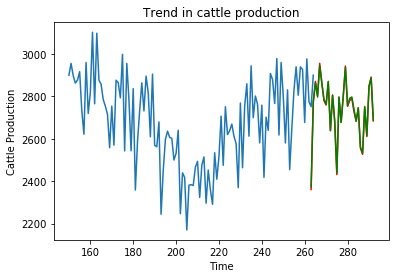

In [78]:
plt.plot(data.index[150:], data["cattle"][150:], label = "True trend")
plt.plot(bvar_uncon_mean.index + data.index[-1] - 1, bvar_uncon_mean["cattle_forecast"], color = "red", label = "Uncond. BVAR forecast")
plt.plot(bvar_uncon_mean.index + data.index[-1] - 1, bvar_con_mean["cattle_forecast"], color = "green", label = "Cond. BVAR forecast")

plt.legend()
#plt.fill_between(bvar_uncon_mean.index + data.index[-1] - 1, bvar_uncon_ub["cattle_forecast"] - bvar_uncon_lb["cattle_forecast"])
plt.title("Trend in cattle production")
plt.xlabel("Time")
plt.ylabel("Cattle Production")
plt.gca().legend().remove()

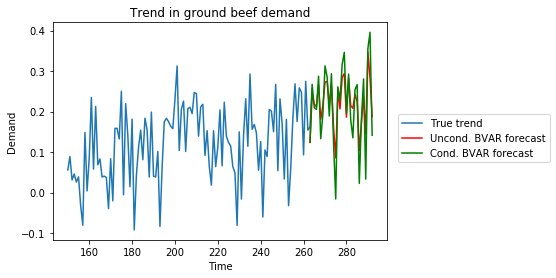

In [80]:
plt.plot(data.index[150:], data["demandall_uncooked_ground_beef"][150:], label = "True trend")
plt.plot(bvar_uncon_mean.index + data.index[-1] - 1, bvar_uncon_mean["demandall_uncooked_ground_beef_forecast"], color = "red", label = "Uncond. BVAR forecast")
plt.plot(bvar_uncon_mean.index + data.index[-1] - 1, bvar_con_mean["demandall_uncooked_ground_beef_forecast"], color = "green", label = "Cond. BVAR forecast")

plt.legend()
#plt.fill_between(bvar_uncon_mean.index + data.index[-1] - 1, bvar_uncon_ub["cattle_forecast"] - bvar_uncon_lb["cattle_forecast"])
plt.title("Trend in ground beef demand")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.gca().legend(bbox_to_anchor = (1.5, 0.6))

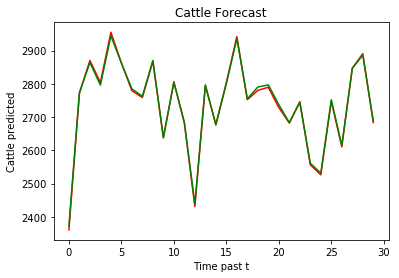

In [81]:
plt.plot(bvar_uncon_mean.index, bvar_uncon_mean["cattle_forecast"], color = "red", label = "Uncond. BVAR forecast")
plt.plot(bvar_con_mean.index, bvar_con_mean["cattle_forecast"], color = "green", label = "Cond. BVAR forecast")
plt.title("Cattle Forecast")
plt.xlabel("Time past t")
plt.ylabel("Cattle predicted")
plt.gca().legend().remove()

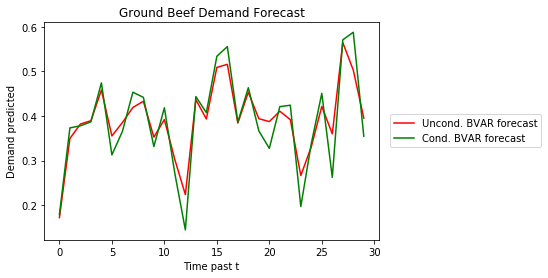

In [83]:
plt.plot(bvar_uncon_mean.index, bvar_uncon_mean["demandall_uncooked_beef_steaks_forecast"], color = "red", label = "Uncond. BVAR forecast")
plt.plot(bvar_con_mean.index, bvar_con_mean["demandall_uncooked_beef_steaks_forecast"], color = "green", label = "Cond. BVAR forecast")
plt.title("Ground Beef Demand Forecast")
plt.xlabel("Time past t")
plt.ylabel("Demand predicted")
plt.gca().legend(bbox_to_anchor = (1.5, 0.6))